In [1]:
# Import necessary libraries
import os
import time
import pyvisa
import numpy as np
from dataclasses import dataclass
from typing import  Dict
import matplotlib.pyplot as plt
from pathlib import Path

# Set matplotlib to display in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("All dependency libraries imported successfully!")


All dependency libraries imported successfully!


In [2]:
# Import existing tools and classes
current_dir = Path.cwd()
tools_dir = current_dir / "../Tools"

bvc_tools_path = tools_dir / "BVC_Tools.ipynb"

%run $bvc_tools_path

print("Tool classes imported successfully!")

All dependency libraries imported successfully!
Jupyter signal generator class definition completed!
Tool classes imported successfully!


In [ ]:
# Device parameter configuration class
@dataclass
class DAQParams:
    """DAQ device parameter configuration"""
    # Basic parameters
    device_ip: str = "127.0.0.1"
    module_name: str = "S2_M4901"
    board_name: str = "S0_M1210"
    
    # Sample rate
    sample_rate: int = 4  # 4GHz
    
    # Channel enable
    channel_en: Dict[str, bool] = None
    
    # Trigger parameters
    trigger_source: str = "Internal"  # Internal/External/Level
    in_trigger_repeat: int = 4294967295
    in_trigger_cycle: float = 0.001
    level_value: float = 0.5  # Level trigger threshold
    
    # Acquisition parameters
    pre_sample: int = 32 * 1024  # Pre-sample points
    pst_sample: int = 32 * 1024  # Post-sample points
    working_mode: str = "Stream"  # Stream/RingBuffer
    
    # Storage parameters
    save_enable: Dict[str, bool] = None
    save_file_path: str = "/UserSpace"
    save_file_size: int = 1024 * 1024 * 1024  # 1GB
    
    # DDC parameters
    ddc_enable: Dict[str, bool] = None
    extract_multiple: int = 1
    nco_frequency: float = 0.0  # NCO frequency
    
    # Quantization parameters
    quantization_bits: int = 14
    
    # Display parameters
    show_data_nums: int = 2
    result_dir: str = "./result"
    fft_result_dir: str = "./fft_result"
    
    def __post_init__(self):
        if self.channel_en is None:
            self.channel_en = {"CH1": True, "CH2": True}
        if self.save_enable is None:
            self.save_enable = {"CH1": True, "CH2": True}
        if self.ddc_enable is None:
            self.ddc_enable = {"CH1": False, "CH2": False}

print("DAQ parameter class definition completed!")

DAQ parameter class definition completed!


In [ ]:
class DAQController:
    """DAQ comprehensive controller"""
    
    def __init__(self):
        self.bvc_tools = BVCTools()
        self.scpi_query = None
        self.scpi_write = None
        self.scpi_read = None
        
        # Data type mapping
        self.data_type_map = {
            3: np.int8,
            5: np.int16,
            6: np.int16  # QI splicing, each is int16
        }
        self.data_type_len_map = {
            np.int8: 1,
            np.int16: 2,
        }
        
    def connect_device(self, params: DAQParams):
        """Connect to device"""
        try:
            visa_resource = f'TCPIP::{params.device_ip}::5555::SOCKET'
            rm = pyvisa.ResourceManager('@py')
            session = rm.open_resource(visa_resource)
            session.write_termination = '\n'
            session.read_termination = '\n'
            session.timeout = 50000
            
            self.scpi_query = session.query
            self.scpi_write = session.write
            self.scpi_read = session.read
            
            print(f"Successfully connected to device: {params.device_ip}")
            return True
        except Exception as e:
            print(f"Failed to connect to device: {e}")
            return False
    
    def get_device_info(self, params: DAQParams):
        """Get device information"""
        try:
            device_name = self.scpi_query(':SYS:DEVice:NAMe?').replace('\n', '').split(',')
            module_names = self.scpi_query(':SYS:DEVice:MODUles?').replace('\n', '').split(',')
            
            model_info = {}
            for module_name in module_names:
                module_dict = {}
                funcs = self.scpi_query(f':SYS:DEVice:MODUles:FUNC? {module_name}').replace('\n', '').split(',')
                in_chnls = []
                out_chnls = []
                for func in funcs:
                    if func == 'AWG':
                        in_chnls = self.scpi_query(f':SYS:DEVice:MODUles:CHNLs:OUT? {module_name}').replace('\n', '').split(',')
                    if func == 'Digitizer':
                        out_chnls = self.scpi_query(f':SYS:DEVice:MODUles:CHNLs:IN? {module_name}').replace('\n', '').split(',')
                module_dict["AWG"] = in_chnls
                module_dict["Digitizer"] = out_chnls
                model_info[module_name] = module_dict
            
            print(f"Device name: {device_name}")
            print(f"Module information: {model_info}")
            return device_name, model_info
        except Exception as e:
            print(f"Failed to get device information: {e}")
            return None, None
    
    def configure_working_mode(self, params: DAQParams):
        """Configure working mode"""
        try:
            # Check current working mode
            current_mode = self.scpi_query(f':DAQ:ACQuire:WKMode? {params.module_name},')
            print(f"Current working mode: {current_mode}")
            
            if current_mode != params.working_mode:
                self.scpi_query(f':DAQ:ACQuire:WKMode {params.module_name},{params.working_mode}')
            
            return True
        except Exception as e:
            print(f"Failed to configure working mode: {e}")
            return False
    def configure_sample_rate(self, params: DAQParams):
        """Configure sample rate"""
        try:
            self.scpi_query(f':DAQ:ACQuire:ADC:SRATe {params.module_name},{params.sample_rate}')
            self.bvc_tools.sync(params.device_ip, params.module_name, params.board_name)
            return True
        except Exception as e:
            print(f"Failed to configure sample rate: {e}")
            return False
    
    def configure_trigger(self, params: DAQParams):
        """Configure trigger"""
        try:
            if params.trigger_source == "Internal":
                self.scpi_query(f':SAT:TRIGger:SOURce {params.board_name},Internal')
                self.scpi_query(f':SAT:TRIGger:INTernal:REPeat {params.board_name},{params.in_trigger_repeat}')
                self.scpi_query(f':SAT:TRIGger:INTernal:CYCle {params.board_name},{params.in_trigger_cycle}')
                
                self.scpi_query(f':DAQ:TRIGger:SOURce {params.module_name},PXISTARTrig')
                self.scpi_query(f':DAQ:TRIGger:INTernal:REPeat {params.module_name},{params.in_trigger_repeat}')
                self.scpi_query(f':DAQ:TRIGger:INTernal:CYCle {params.module_name},{params.in_trigger_cycle}')
            elif params.trigger_source == "External":
                self.scpi_query(f':SAT:TRIGger:SOURce {params.board_name},External')
                self.scpi_query(f':DAQ:TRIGger:SOURce {params.module_name},PXISTARTrig')
            elif params.trigger_source == "Level":
                self.scpi_query(f':DAQ:TRIGger:SOURce {params.module_name},Level')
                for key, value in params.channel_en.items():
                    if value:
                        self.scpi_query(f':DAQ:TRIGger:EDGe:LEVel {key},{params.level_value}')
            else:
                print(f"Error: {params.trigger_source} does not exist")
            return True
        except Exception as e:
            print(f"Failed to configure trigger: {e}")
            return False
    
    def configure_channels(self, params: DAQParams):
        """Configure channels"""
        try:
            for key, value in params.channel_en.items():
                # Channel enable
                self.scpi_query(f':DAQ:CHANnel:EN {key},{value}')
                
                if value:
                    # Quantization bits
                    self.scpi_query(f':DAQ:CHANnel:QUANtization {key},{params.quantization_bits}')
                    # Pre-sample points
                    self.scpi_query(f':DAQ:ACQuire:PRESample {key},{params.pre_sample}')
                    # Post-sample points
                    self.scpi_query(f':DAQ:ACQuire:PSTSample {key},{params.pst_sample}')
            return True
        except Exception as e:
            print(f"Failed to configure channels: {e}")
            return False
    
    def configure_ddc(self, params: DAQParams):
        """Configure DDC"""
        try:
            # Set extract multiple
            self.scpi_query(f':DAQ:ACQuire:ExtractMultiple {params.module_name},{params.extract_multiple}')
            
            for key, value in params.ddc_enable.items():
                if key in params.channel_en and params.channel_en[key]:
                    self.scpi_query(f':DAQ:CHANnel:DDC:EN {key},{value}')
                    if value:
                        self.scpi_query(f':DAQ:CHANnel:DDC:NCOFrequence {key},{params.nco_frequency}')
            return True
        except Exception as e:
            print(f"Failed to configure DDC: {e}")
            return False
    
    def configure_save(self, params: DAQParams):
        """Configure storage"""
        try:
            for key, value in params.save_enable.items():
                if key in params.channel_en and params.channel_en[key]:
                    self.scpi_query(f':DAQ:UPSTream:SAVe:EN {key},{value}')
                    if value:
                         # Save path
                        self.scpi_query(f':DAQ:UPSTream:SAVe:DIRectory {key},{params.save_file_path}')
                        # Single file size
                        self.scpi_query(f':DAQ:UPSTream:SAVe:SIZe {key},{params.save_file_size}')
            return True
        except Exception as e:
            print(f"Failed to configure storage: {e}")
            return False
    def start_acquisition(self, params: DAQParams):
        """Start acquisition"""
        try:
            self.scpi_query(f':SYS:Control:RUN {params.module_name}')
            self.scpi_query(f':SAT:TRIGger:INTernal:Run {params.board_name}')
            print("DAQ acquisition started")
            return True
        except Exception as e:
            print(f"Failed to start acquisition: {e}")
            return False
    
    def stop_acquisition(self, params: DAQParams):
        """Stop acquisition"""
        try:
            self.scpi_query(f':SAT:TRIGger:INTernal:Stop {params.board_name}')
            self.scpi_query(f':SYS:Control:STOP {params.module_name}')
            
            # Close storage
            for key, value in params.save_enable.items():
                if key in params.channel_en and params.channel_en[key]:
                    self.scpi_query(f':DAQ:UPSTream:SAVe:EN {key},False')
            
            print("DAQ acquisition stopped")
            return True
        except Exception as e:
            print(f"Failed to stop acquisition: {e}")
            return False
    
    def get_latest_data_file(self, params: DAQParams):
        """Get latest data file"""
        try:
            # Get file list
            original_list = os.listdir(params.save_file_path)
            # Remove unnecessary folders
            filtered_list = [item for item in original_list if item not in ['WaveList', 'NSQC']]
            # Sort by date and time (newest first)
            sorted_list = sorted(filtered_list, reverse=True)
            
            if not sorted_list:
                print("No data files found")
                return None
            
            latest_folder = sorted_list[0]
            print(f"Latest data folder: {latest_folder}")
            return latest_folder
        except Exception as e:
            print(f"Failed to get data file: {e}")
            return None
    
    def parse_data_file(self, file_path: str, show_nums: int = 2):
        """Parse data file"""
        try:
            if not os.path.exists(file_path):
                print(f"File does not exist: {file_path}")
                return None
            
            file_obj = open(file_path, 'rb')
            head_length = 32  # Header length
            file_len = os.path.getsize(file_path)  # Total file length
            read_len = 0  # File length already read
            
            data_packets = []
            
            for i in range(show_nums):
                if read_len >= file_len:
                    break
                
                # Read header
                head_data = file_obj.read(head_length)
                if len(head_data) < head_length:
                    break
                
                read_len += head_length
                
                # Parse header information
                pack_length = np.frombuffer(head_data[8:12], dtype=np.uint32)[0]  # Packet length
                data_length = pack_length - head_length  # Data length
                data_type = np.frombuffer(head_data[24:25], dtype=np.int8)[0]  # Data type
                prt = np.frombuffer(head_data[4:8], dtype=np.uint32)[0]  # Packet count
                
                # Map data type
                np_data_type = self.data_type_map.get(data_type, np.int16)
                
                # Read data
                data_bytes = file_obj.read(data_length)
                if len(data_bytes) < data_length:
                    break
                
                read_len += data_length
                
                # Parse data
                data = np.frombuffer(data_bytes, dtype=np_data_type)
                
                data_packets.append({
                    'prt': prt,
                    'data_type': data_type,
                    'data_length': data_length,
                    'data': data
                })
                
                print(f"Packet {i}: PRT={prt}, Data type={data_type}, Length={data_length}, Read={read_len}/{file_len}")
            
            file_obj.close()
            return data_packets
        except Exception as e:
            print(f"Failed to parse data file: {e}")
            return None
    
    def visualize_data(self, data_packets: list, params: DAQParams):
        """Visualize data"""
        try:
            # Create result directory
            result_dir = current_dir / params.result_dir
            
            
            if not os.path.exists(result_dir):
                os.makedirs(result_dir)
            
            for i, packet in enumerate(data_packets):
                plt.figure(figsize=(12, 6))
                plt.plot(packet['data'])
                plt.title(f'Data {packet["prt"]} - Sample Data')
                plt.xlabel('Sample Points')
                plt.ylabel('Amplitude')
                plt.grid(True)
                
                # Save image
                plt.savefig(f'{result_dir}/data_packet_{packet["prt"]}.png')
                plt.show()
                plt.close()
            
            print(f"Data visualization completed, images saved in {result_dir} directory")
            return True
        except Exception as e:
            print(f"Failed to visualize data: {e}")
            return False
    
    def analyze_data_fft(self, data_packets: list, params: DAQParams):
        """FFT analyze data"""
        try:
            # Create FFT result directory
            fft_result_dir = current_dir / params.fft_result_dir
            if not os.path.exists(fft_result_dir):
                os.makedirs(fft_result_dir)
            
            sample_rate = params.sample_rate * 1e9  # Convert to Hz
            
            for i, packet in enumerate(data_packets):
                data = packet['data']
                duration = len(data) / sample_rate
                t = np.linspace(0, duration, len(data), endpoint=False)
                
                # Use BVC_Tools FFT analysis
                self.bvc_tools.plot_fft(
                    image_num=i,
                    signal=data,
                    t=t,
                    fs=sample_rate
                )
                
                print(f"Packet {packet['prt']} FFT analysis completed")
            
            return True
        except Exception as e:
            print(f"Failed to analyze FFT: {e}")
            return False

print("DAQ controller class definition completed!")

DAQ controller class definition completed!


In [5]:
# Create DAQ controller instance
daq_controller = DAQController()
print("DAQ controller instance created successfully!")

DAQ controller instance created successfully!


In [6]:
# Example 1: Basic Stream mode data acquisition
print("=== Example 1: Basic Stream mode data acquisition ===")
stream_params = DAQParams(
    device_ip="127.0.0.1",
    module_name="S2_M4901",
    board_name="S0_M1210",
    working_mode="Stream",
    trigger_source="Internal",
    pre_sample=32 * 1024,
    pst_sample=32 * 1024,
    show_data_nums=2
)

=== Example 1: Basic Stream mode data acquisition ===


In [7]:
# 1. Connect to device
daq_controller.connect_device(stream_params)

# 2. Get device information
device_name, model_info = daq_controller.get_device_info(stream_params)

# 3. Configure working mode
daq_controller.configure_working_mode(stream_params)

Successfully connected to device: 127.0.0.1
Device name: ['TestDevice']
Module information: {'S0_M1210': {'AWG': [], 'Digitizer': []}, 'S0_M2301': {'AWG': [], 'Digitizer': []}, 'S2_M4901': {'AWG': ['CH1', 'CH2'], 'Digitizer': ['CH1', 'CH2']}}
Current working mode: RingBuffer
Failed to configure working mode: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.


False

In [8]:
# 1. Connect to device
daq_controller.connect_device(stream_params)

# 2. Get device information
device_name, model_info = daq_controller.get_device_info(stream_params)

# 7. Configure DDC (if needed)
daq_controller.configure_ddc(stream_params)

# 4. Configure sample rate
daq_controller.configure_sample_rate(stream_params)

# 5. Configure trigger
daq_controller.configure_trigger(stream_params)

# 6. Configure channels
daq_controller.configure_channels(stream_params)

# 8. Configure storage
daq_controller.configure_save(stream_params)

Successfully connected to device: 127.0.0.1
Failed to get device information: [Errno 111] Connection refused
Failed to configure DDC: [Errno 32] Broken pipe
Failed to configure sample rate: [Errno 32] Broken pipe
Failed to configure trigger: [Errno 32] Broken pipe
Failed to configure channels: [Errno 32] Broken pipe
Failed to configure storage: [Errno 32] Broken pipe


False

In [9]:
# 9. Start acquisition
daq_controller.start_acquisition(stream_params)
time.sleep(5)
# 10. Stop acquisition
daq_controller.stop_acquisition(stream_params)

Failed to start acquisition: [Errno 32] Broken pipe
Failed to stop acquisition: [Errno 32] Broken pipe


False

Starting data analysis...
Latest data folder: 25-07-17_10-10-32
Packet 0: PRT=0, Data type=5, Length=131072, Read=131104/45230880
Packet 1: PRT=1, Data type=5, Length=131072, Read=262208/45230880


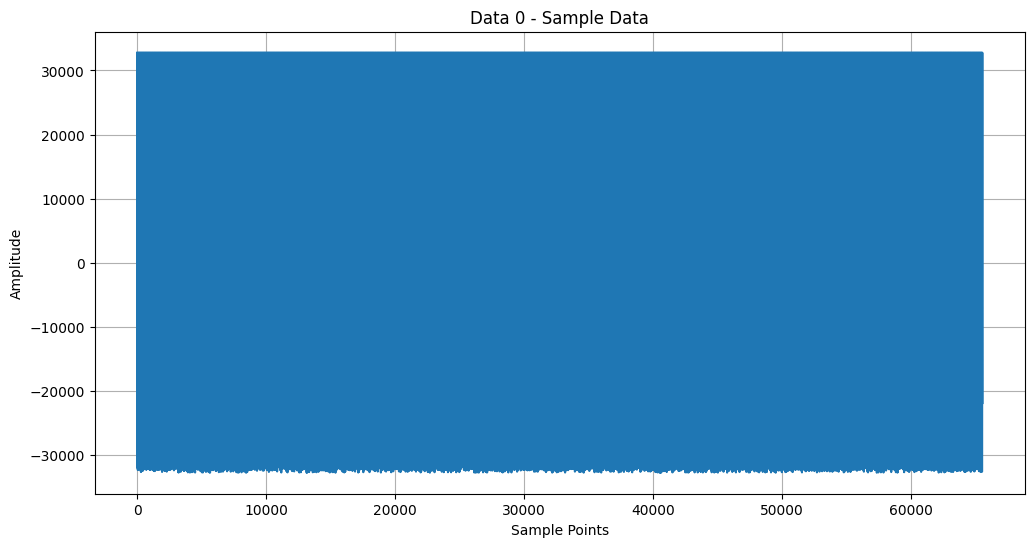

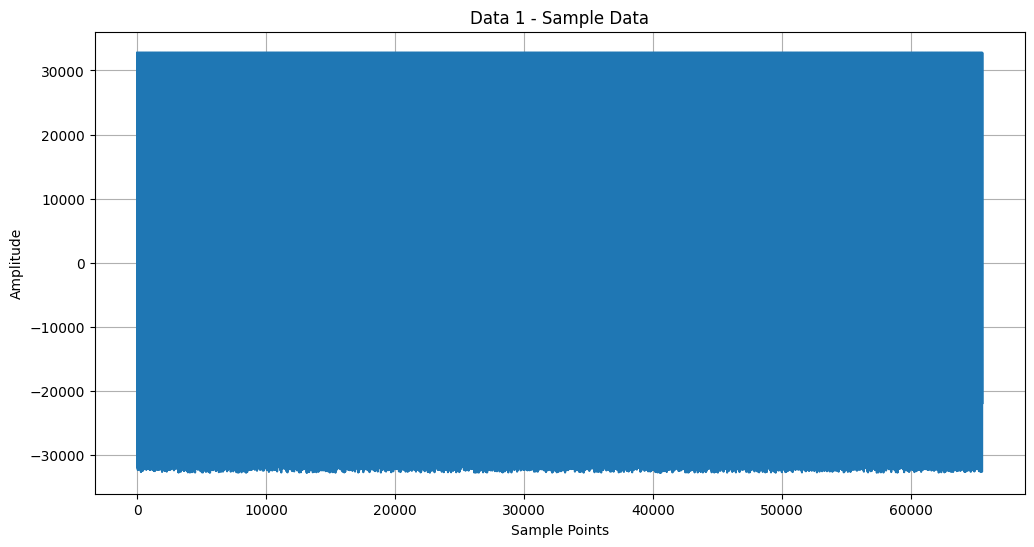

Data visualization completed, images saved in /home/digilab/SUA8000_Examples/remote_control_V3/demos/result directory


/home/digilab/.conda/envs/JupyterServer/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/digilab/.conda/envs/JupyterServer/lib/python3.10/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/digilab/.conda/envs/JupyterServer/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


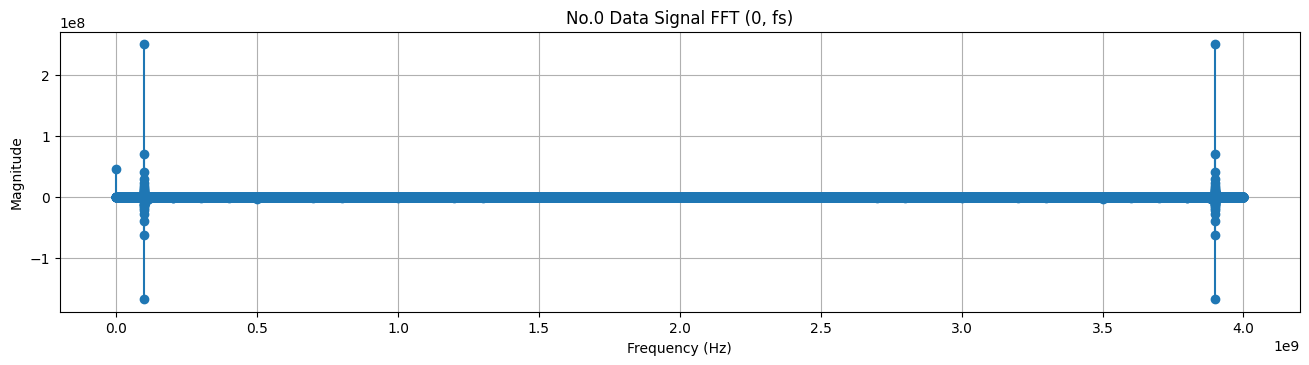

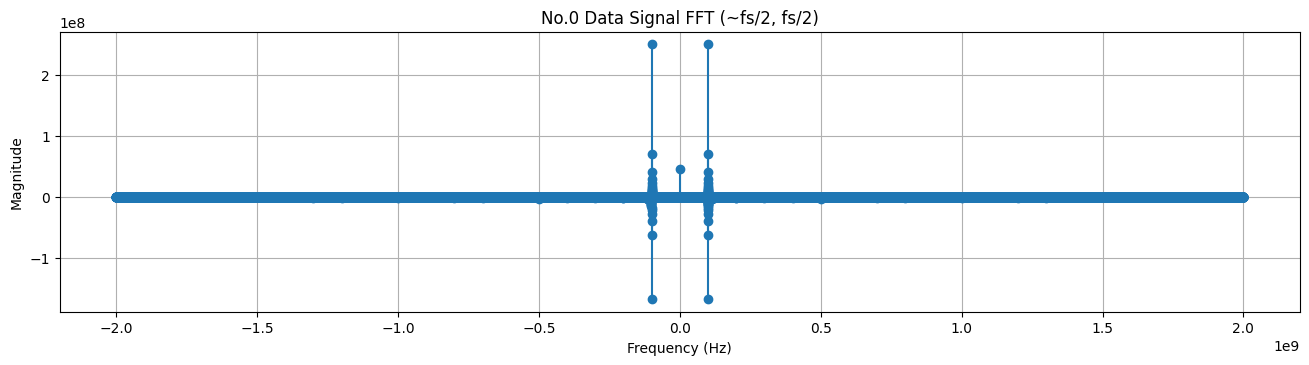

signal fft max: (250745087.48029637-770918505.0996933j)
signal fft shifted max: (250745087.48029637-770918505.0996933j)
Packet 0 FFT analysis completed


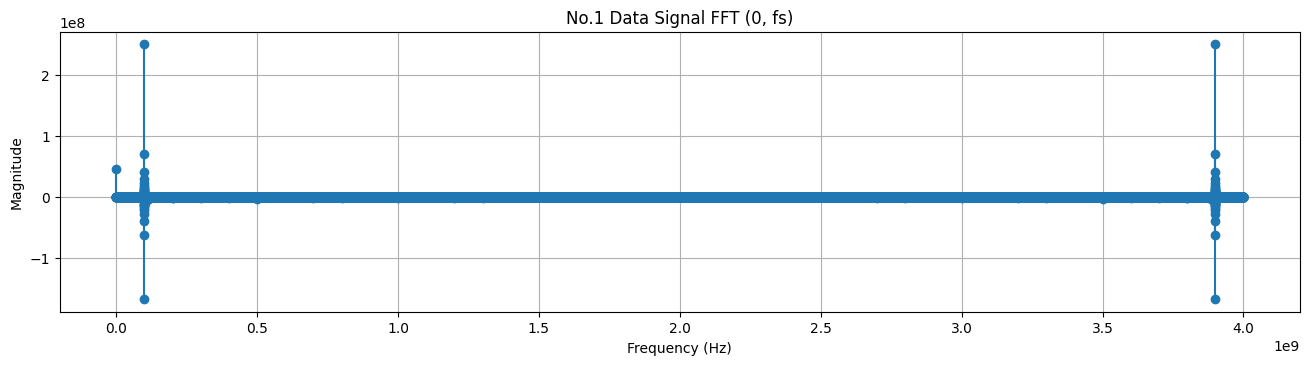

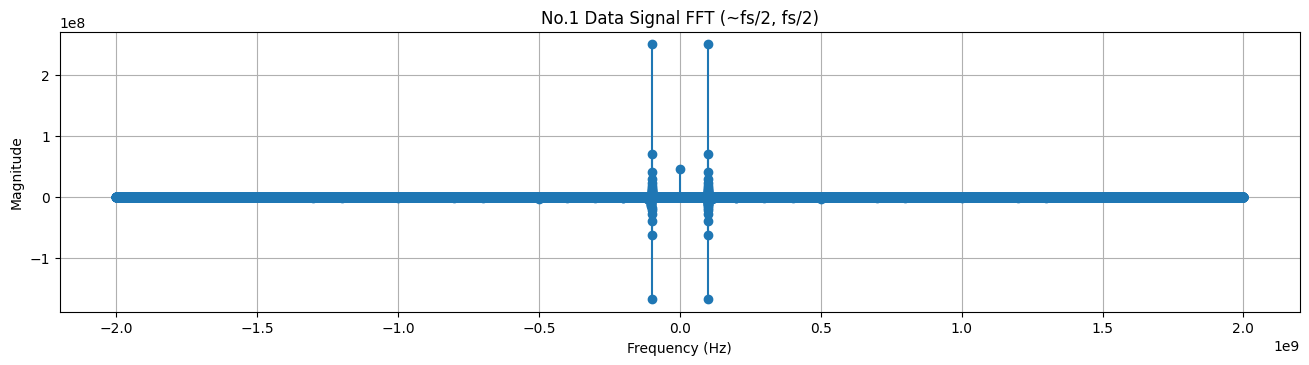

signal fft max: (250745087.48029637-770918505.0996933j)
signal fft shifted max: (250745087.48029637-770918505.0996933j)
Packet 1 FFT analysis completed
Data analysis completed


In [10]:
print("Starting data analysis...")
        
# Get latest data file
latest_folder = daq_controller.get_latest_data_file(stream_params)

# Build file path
file_path = f'{stream_params.save_file_path}/{latest_folder}/CH1_0.data'

# Parse data file
data_packets = daq_controller.parse_data_file(file_path, stream_params.show_data_nums)

# Visualize data
daq_controller.visualize_data(data_packets, stream_params)

# FFT analysis
daq_controller.analyze_data_fft(data_packets, stream_params)

print("Data analysis completed")